# Module version used

- torch     1.4.0
- numpy 1.18.1
- CPython 3.6.9
- IPython 7.10.2
- numpy     1.17.4
- PIL.Image 6.2.1
- pandas    0.25.3

## Objective
Objective of this project is to classify Cat-Dog Dataset collected from Kaggle (https://www.kaggle.com/c/dogs-vs-cats/data). 

This implementation considers only the codes used in this repository.

## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
print(os.listdir("../../../../MEGA/DatabaseLocal/dogs-vs-cats/"))

['test1', 'train', 'kagglecatsanddogs_3367a.zip', 'train.zip', 'MSR-LA - 3467.docx', 'test1.zip', 'sampleSubmission.csv', 'PetImages', 'dogs-vs-cats.zip', 'readme[1].txt']


## Dataset

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

1. Download the dataset from the following link (https://www.kaggle.com/c/dogs-vs-cats/data). (Cat-Dog Dataset from Kaggle)

2. Dataset contains three file:
  - sampleSubmission.csv
  - test1.zip
  - train.zip


## Preparing the Dataset

In [3]:
datapath = "../../../../MEGA/DatabaseLocal/dogs-vs-cats/"

filenames = os.listdir(datapath+"train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,dog.9738.jpg,1
1,dog.4938.jpg,1
2,cat.1129.jpg,0
3,dog.11927.jpg,1
4,dog.8406.jpg,1


In [5]:
df.tail()

,filename,category
24995,dog.2474.jpg,1
24996,cat.7146.jpg,0
24997,dog.6588.jpg,1
24998,cat.7444.jpg,0
24999,dog.3949.jpg,1


#### See Total In count

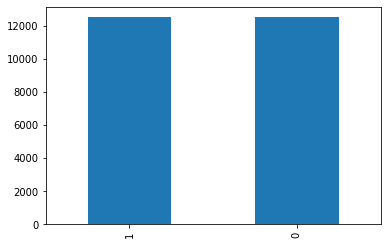

In [6]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

### See sample image

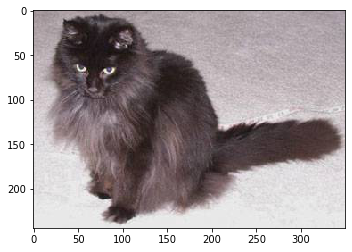

In [7]:
import random
sample = random.choice(filenames)
image = Image.open(datapath+"train/"+sample)
plt.imshow(image)

In [8]:
df.index.values

array([    0,     1,     2, ..., 24997, 24998, 24999])

### Implementing a Custom DataLoader Class

In [9]:
class CatDogDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, img_dir, transform=None):
        filenames = os.listdir(img_dir)
        categories = []
        for filename in filenames:
            category = filename.split('.')[0]
            if category == 'dog':
                categories.append(1)
            else:
                categories.append(0)
        
        df = pd.DataFrame({'filename': filenames,
                           'category': categories})
    
        self.img_dir = img_dir
        self.img_names = df['filename'].values
        self.y = df['category'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [10]:
# Note that transforms.ToTensor() already divides pixels by 255. internally
custom_transform = transforms.Compose([#transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CatDogDataset(img_dir=datapath+'train/',
                              transform=custom_transform)

test_dataset = CatDogDataset(img_dir=datapath+'test1/',
                             transform=custom_transform)

batch_size=64

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)

Epoch: 1 | Batch index: 0 | Batch size: 64


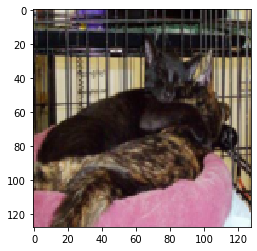

Epoch: 2 | Batch index: 0 | Batch size: 64


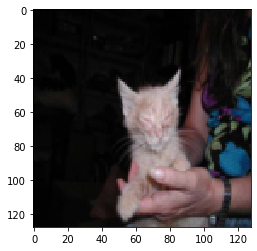

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        plt.imshow(np.transpose(x[0], (1, 2, 0)))
        plt.show()
        x = x.to(device)
        y = y.to(device)
        break

## Training

In [12]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10
grayscale = "False"

# Architecture
num_features = 128*128
num_classes = 2

Device: cuda:0


In [13]:
##########################
### MODEL
##########################
class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.classifier = nn.Sequential(
                nn.Linear(512*4*4, 4096),
                nn.ReLU(),   
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )
            
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*4*4))
        probas = F.softmax(logits, dim=1)

        return logits, probas

torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [14]:
print(model)

VGG16(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## Training

In [15]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [16]:
start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time()  - start_time)/60))

Epoch: 001/010 | Batch 0000/0391 | Cost: 6531.8467
Epoch: 001/010 | Batch 0050/0391 | Cost: 0.9610
Epoch: 001/010 | Batch 0100/0391 | Cost: 0.7037
Epoch: 001/010 | Batch 0150/0391 | Cost: 0.6495
Epoch: 001/010 | Batch 0200/0391 | Cost: 0.6255
Epoch: 001/010 | Batch 0250/0391 | Cost: 0.6758
Epoch: 001/010 | Batch 0300/0391 | Cost: 0.7039
Epoch: 001/010 | Batch 0350/0391 | Cost: 0.5970
Epoch: 001/010 | Train: 62.924%
Time elapsed: 6.97 min
Epoch: 002/010 | Batch 0000/0391 | Cost: 0.6215
Epoch: 002/010 | Batch 0050/0391 | Cost: 0.5410
Epoch: 002/010 | Batch 0100/0391 | Cost: 0.6547
Epoch: 002/010 | Batch 0150/0391 | Cost: 0.6624
Epoch: 002/010 | Batch 0200/0391 | Cost: 0.6172
Epoch: 002/010 | Batch 0250/0391 | Cost: 0.6316
Epoch: 002/010 | Batch 0300/0391 | Cost: 0.6285
Epoch: 002/010 | Batch 0350/0391 | Cost: 0.5928
Epoch: 002/010 | Train: 64.300%
Time elapsed: 13.94 min
Epoch: 003/010 | Batch 0000/0391 | Cost: 0.5737
Epoch: 003/010 | Batch 0050/0391 | Cost: 0.6308
Epoch: 003/010 | Batch

cat


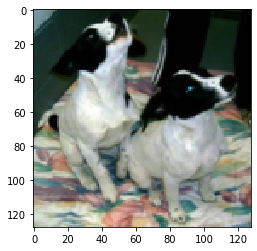

In [23]:
for batch_idx, (features, targets) in enumerate(test_loader):
    
    features = features
    targets = targets
    break
    
index = 5
nhwc_img = np.transpose(features[index], axes=(1, 2, 0))
# nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhwc_img, cmap='Greys');
img = np.transpose(features[index].unsqueeze(-1), axes=(3,0, 1, 2))
model.eval()
logits, probas = model(img.to(device)[0, None])
a = probas==probas.max()
if a[0][0] == False:
    print('dog')
else:
    print('cat')